<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIP Explainability**

In [1]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install -r requirements.txt

fatal: destination path 'Transformer-MM-Explainability' already exists and is not an empty directory.


# **CLIP**

In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [31]:
#@title Control context expansion (number of attention layers to consider)
num_layers =  10#@param {type:"number"}

In [33]:
def interpret(image, texts, model, device):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i <=num_layers:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    return image_relevance

In [34]:
def show_image_relevance(image_relevance, image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    plt.imshow(vis)

In [5]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
}

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

100%|████████████████████████████████████████| 354M/354M [00:02<00:00, 147MiB/s]


In [7]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

text: a man with eyeglasses


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


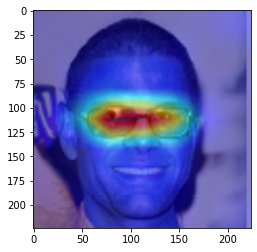

In [36]:
img = preprocess(Image.open("CLIP/glasses.png")).unsqueeze(0).to(device)
texts = ["a man with eyeglasses"]
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a man with lipstick


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


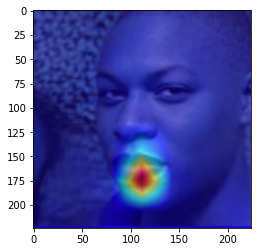

In [37]:
img = preprocess(Image.open("CLIP/lipstick.png")).unsqueeze(0).to(device)
texts = ["a man with lipstick"]
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a rocket standing on a launchpad


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


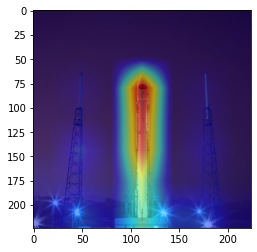

In [38]:
img = preprocess(Image.open("CLIP/rocket.jpg")).unsqueeze(0).to(device)
texts = ["a rocket standing on a launchpad"]
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a zebra


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


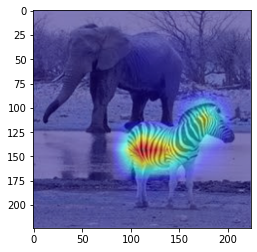

text: an elephant


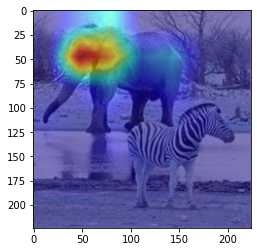

text: a lake


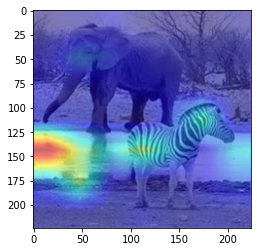

In [40]:
img = preprocess(Image.open("CLIP/el2.png")).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'a lake']
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a zebra


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


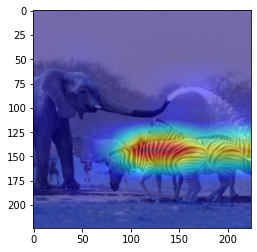

text: an elephant


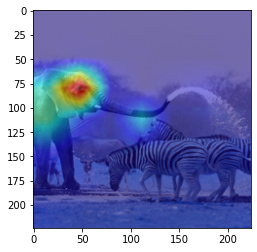

text: water


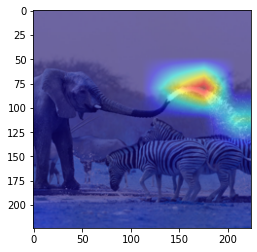

In [42]:
img = preprocess(Image.open("CLIP/el3.png")).unsqueeze(0).to(device)
texts = ['a zebra', 'an elephant', 'water']
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: an elephant


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


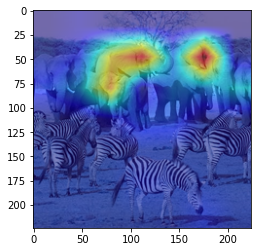

text: a zebra


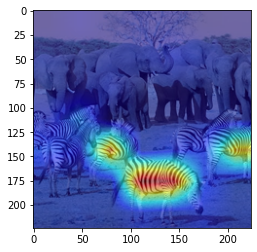

In [44]:
img = preprocess(Image.open("CLIP/el4.png")).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: an elephant


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


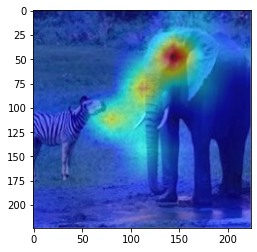

text: a zebra


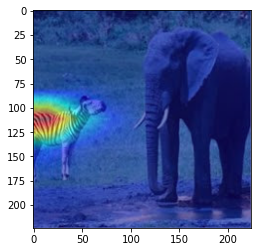

In [45]:
img = preprocess(Image.open("CLIP/el1.png")).unsqueeze(0).to(device)
texts = ['an elephant', 'a zebra']
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a dog


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


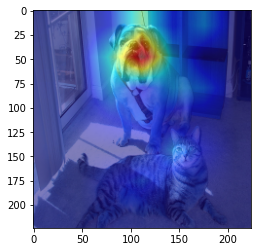

text: a cat


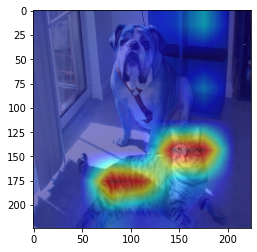

In [46]:
img = preprocess(Image.open("CLIP/catdog.png")).unsqueeze(0).to(device)
texts = ["a dog", "a cat"]
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a labrador


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


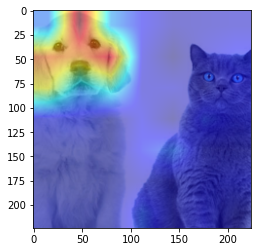

text: a tabby cat


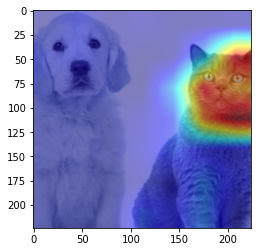

In [47]:
img = preprocess(Image.open("CLIP/dogcat2.png")).unsqueeze(0).to(device)
texts = ["a labrador", "a tabby cat"]
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a parrot


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


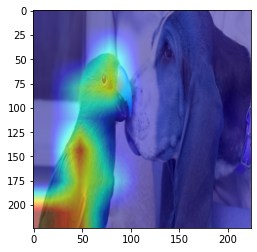

text: a basset hound


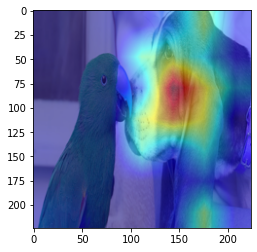

In [48]:
img = preprocess(Image.open("CLIP/dogbird.png")).unsqueeze(0).to(device)
texts = ["a parrot", "a basset hound"]
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()

text: a portrait of an astronaut


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


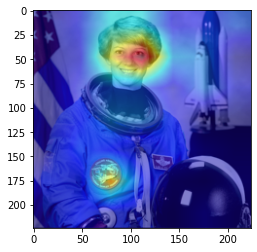

text: a rocket


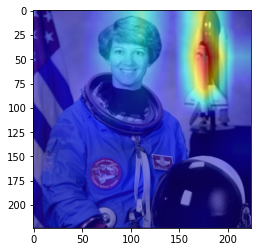

text: an astronaut suit


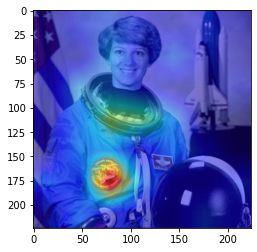

In [51]:
img = preprocess(Image.open("CLIP/astronaut.png")).unsqueeze(0).to(device)
texts = ["a portrait of an astronaut", "a rocket", "an astronaut suit"]
text = clip.tokenize(texts).to(device)

R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + 'text: ' + texts[i] + color.END)
  show_image_relevance(R_image[i], img)
  plt.show()